# Deep Learning LSTM Model

## Configuration

In [6]:
INPUT_FILE_NAME = 'vale3.csv'
DATA_USE_COLONS = [0, 1]
WINDOW_SIZE = 30
DIFFERENCE_FEATURES_NUM = 4
TRAIN_EPOCHS_NUM = 50
SCALER_TYPE = 'STD' # 'MINMAX'

## Prepare Environment

In [7]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Other
import warnings
import pprint
import os

### Set Config

In [8]:
RAW_DATA_DIR = os.curdir + "/data/raw/"
PROCESSED_DATA_DIR = os.curdir + "/data/processed/"
TRAIN_RATIO = 0.8
scaler = MinMaxScaler() if SCALER_TYPE == 'MINMAX' else StandardScaler()

In [9]:
%matplotlib inline
%load_ext autoreload

# pyplot
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rc('figure', figsize = (16, 8))
plt.rc('font', size = 15)
plt.rc('legend', fontsize = 15)

# seaborn
rc = { 'savefig.dpi': 500, 
       'figure.autolayout': True, 
       'figure.figsize': [16, 9], 
       'axes.labelsize': 18,
       'axes.titlesize': 18, 
       'font.size': 10, 
       'lines.linewidth': 1.0, 
       'lines.markersize': 8, 
       'legend.fontsize': 15,
       'xtick.labelsize': 15, 
       'ytick.labelsize': 15 }

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

# pandas
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load & preprocess raw data

In [10]:
raw_df = pd.read_csv(
    RAW_DATA_DIR + INPUT_FILE_NAME,
    encoding = 'utf8',
    delimiter = ',',
    usecols = DATA_USE_COLONS,
    header = 0,
    names = ['date', 'price'],
    verbose = True
)

raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df.index = raw_df['date']

decomposition = seasonal_decompose(raw_df['price'], period = WINDOW_SIZE, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df = pd.DataFrame(columns = raw_df.columns)
df['date'] = raw_df['date']
df['price'] = raw_df['price']
df['residuals'] = residual.values
df['trend'] = trend.values
df['seasonality'] = seasonal.values

DF_SIZE = df.shape[0]
NAN_RANGE_SIZE = WINDOW_SIZE // 2

df = df[NAN_RANGE_SIZE:DF_SIZE - NAN_RANGE_SIZE]

for i in range(1, DIFFERENCE_FEATURES_NUM + 1):
    df[f'diff_{i}'] = df['price'].diff(periods = i)

df.dropna(inplace=True)

df.to_csv(
    path_or_buf = PROCESSED_DATA_DIR + 'p_' + INPUT_FILE_NAME,
    sep = ',',
    index = False,
    encoding = 'utf8'
)

Tokenization took: 0.50 ms
Type conversion took: 0.50 ms
Parser memory cleanup took: 0.00 ms


### Load preprocessed data

In [11]:
df = pd.read_csv(
    PROCESSED_DATA_DIR + 'p_' + INPUT_FILE_NAME,
    encoding = 'utf8',
    delimiter = ',',
    parse_dates = True,
    index_col = 0,
    verbose = True
)

Tokenization took: 2.00 ms
Type conversion took: 2.00 ms
Parser memory cleanup took: 0.00 ms


## Split Data

In [12]:
total_size = df.shape[0]
train_size = round(total_size * TRAIN_RATIO)
test_size = total_size - train_size

print('Train dataset size:', train_size)
print('Test dataset size:', test_size)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

Train dataset size: 1969
Test dataset size: 492


## Evaluation

In [13]:
evaluation_history = {}

In [14]:
def show_result_model(df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(
        y_forecast,
        index = df_test.index,
        columns = ['forecast']
    )

    mape = mean_absolute_percentage_error(df_test, y_forecast) * 100
    mse = mean_squared_error(df_test, y_forecast, squared = True)

    evaluation_history[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis = 1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Time, days", fontsize=20)
    plt.ylabel("Price, USD", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}\n' + 
    f'Window: {WINDOW_SIZE}, Epochs: {TRAIN_EPOCHS_NUM}', fontsize = 25)

## Modeling

### Data normalization

In [15]:
scaler = scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

In [16]:
def create_dataset(X, y, window):
    Xs, ys = [], []
    
    for i in range(len(X) - window):
        Xs.append(X[i:i + window])        
        ys.append(y[i + window:i + window + 1])
    
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [17]:
X_train, y_train = create_dataset(df_train_scaled, df_train_scaled[:,0], WINDOW_SIZE)
X_test, y_test = create_dataset(df_test_scaled, df_test_scaled[:,0], WINDOW_SIZE)

print(f'X_train shape = {X_train.shape}')
print(f'y_train shape = {y_train.shape}')

X_train shape = (1939, 30, 8)
y_train shape = (1939, 1)


### Build LSTM Model
- reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [18]:
model_lstm = Sequential(name = 'LSTM')

#### Input Layer

In [19]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(
    LSTM(
        units = len(df_train.columns),
        return_sequences = True,
        input_shape = (X_train.shape[1], X_train.shape[2])
    )
)

model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [20]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 10, return_sequences = True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 10, return_sequences = True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 10))
model_lstm.add(Dropout(0.2))

#### Output Layer

In [21]:
model_lstm.add(Dense(units = 1))

### Compile model

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 8)             544       
                                                                 
 dropout (Dropout)           (None, 30, 8)             0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 10)            760       
                                                                 
 dropout_1 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 10)            840       
                                                                 
 dropout_2 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                840    

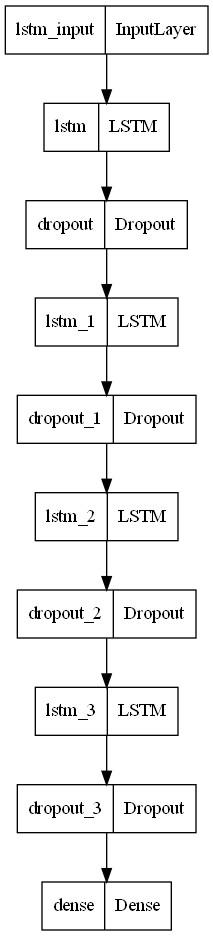

In [22]:
model_lstm.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam',
    metrics = ['mse', 'mape']
)

model_lstm.summary()
keras.utils.plot_model(model_lstm)

### Train model

In [23]:
history = model_lstm.fit(X_train,
                         y_train,
                         epochs = TRAIN_EPOCHS_NUM,
                         batch_size = WINDOW_SIZE,
                         shuffle = False,
                         validation_split = 0.20,
                         verbose = False)
history
history.history.keys()

In [ ]:
best_poch_idx = history.history["loss"].index(min(history.history["loss"]))
print('Min loss', min(history.history["loss"]), 'at', best_poch_idx)

In [ ]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('LSTM Loss')
plt.legend()
plt.show()

### Forecast

In [ ]:
y_forecast = model_lstm.predict(X_test)

In [ ]:
y_test_tmp = np.repeat(y_test, df_train.shape[1], axis = -1)
y_train_tmp = np.repeat(y_train, df_train.shape[1], axis = -1)
y_forecast_tmp = np.repeat(y_forecast, df_train.shape[1], axis = -1)

y_test = scaler.inverse_transform(y_test_tmp)[:,0]
y_train = scaler.inverse_transform(y_train_tmp)[:,0]
y_forecast = scaler.inverse_transform(y_forecast_tmp)[:,0]

In [ ]:
show_result_model(df_test=df_test['price'][WINDOW_SIZE:test_size], 
                  y_forecast=y_forecast[:test_size - WINDOW_SIZE],
                  model_name=f'lstm_{SCALER_TYPE}_{WINDOW_SIZE}_{TRAIN_EPOCHS_NUM}')

In [ ]:
df_train.index

## Results

In [ ]:
evaluation_history